In [208]:
import pandas as pd
import random
import numpy as np
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb
from xgboost import plot_tree

from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [210]:
train_set = pd.read_csv("data/train.csv")
test_set = pd.read_csv("data/test.csv")

test_set['SalePrice'] = -1.0
global_set = pd.concat([train_set, test_set])

# Task 1:
Select a set of 10-15 of the most interesting variables.  Do a pairwise Pearson correlation analysis on all pairs of these variables. Show the result with heat map and find out most positive and negative correlations. 

In [211]:
# suspects = ["SalePrice", "RH", "RL", "RP", "RM", "LotFrontage", "LotArea"]
suspects = ["SalePrice", "LotFrontage", "LotArea", "PoolArea", "YrSold", "OverallQual", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageCars",
            "GarageArea", "YearBuilt", "BedroomAbvGr", "KitchenAbvGr", "MasVnrArea", "YearRemodAdd"]
train_set[suspects].head()

,SalePrice,LotFrontage,LotArea,PoolArea,YrSold,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,YearBuilt,BedroomAbvGr,KitchenAbvGr,MasVnrArea,YearRemodAdd
0,208500,65.0,8450,0,2008,7,856,856,1710,2,548,2003,3,1,196.0,2003
1,181500,80.0,9600,0,2007,6,1262,1262,1262,2,460,1976,3,1,0.0,1976
2,223500,68.0,11250,0,2008,7,920,920,1786,2,608,2001,3,1,162.0,2002
3,140000,60.0,9550,0,2006,7,756,961,1717,3,642,1915,3,1,0.0,1970
4,250000,84.0,14260,0,2008,8,1145,1145,2198,3,836,2000,4,1,350.0,2000


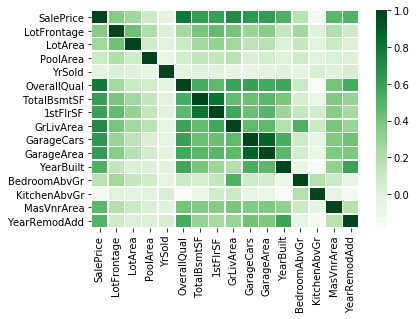

In [215]:
sns.heatmap(train_set[suspects].corr(), cmap="Greens", linewidth=0.5)

In [7]:
train_set[suspects].corr()

,SalePrice,LotFrontage,LotArea,PoolArea,YrSold,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,YearBuilt,BedroomAbvGr,KitchenAbvGr,MasVnrArea,YearRemodAdd
SalePrice,1.000000,0.351799,0.263843,0.092404,-0.028923,0.790982,0.613581,0.605852,0.708624,0.640409,0.623431,0.522897,0.168213,-0.135907,0.477493,0.507101
LotFrontage,0.351799,1.000000,0.426095,0.206167,0.007450,0.251646,0.392075,0.457181,0.402797,0.285691,0.344997,0.123349,0.263170,-0.006069,0.193458,0.088866
LotArea,0.263843,0.426095,1.000000,0.077672,-0.014261,0.105806,0.260833,0.299475,0.263116,0.154871,0.180403,0.014228,0.119690,-0.017784,0.104160,0.013788
PoolArea,0.092404,0.206167,0.077672,1.000000,-0.059689,0.065166,0.126053,0.131525,0.170205,0.020934,0.061047,0.004950,0.070703,-0.014525,0.011723,0.005829
YrSold,-0.028923,0.007450,-0.014261,-0.059689,1.000000,-0.027347,-0.014969,-0.013604,-0.036526,-0.039117,-0.027378,-0.013618,-0.036014,0.031687,-0.008201,0.035743
OverallQual,0.790982,0.251646,0.105806,0.065166,-0.027347,1.000000,0.537808,0.476224,0.593007,0.600671,0.562022,0.572323,0.101676,-0.183882,0.411876,0.550684
TotalBsmtSF,0.613581,0.392075,0.260833,0.126053,-0.014969,0.537808,1.000000,0.819530,0.454868,0.434585,0.486665,0.391452,0.050450,-0.068901,0.363936,0.291066
1stFlrSF,0.605852,0.457181,0.299475,0.131525,-0.013604,0.476224,0.819530,1.000000,0.566024,0.439317,0.489782,0.281986,0.127401,0.068101,0.344501,0.240379
GrLivArea,0.708624,0.402797,0.263116,0.170205,-0.036526,0.593007,0.454868,0.566024,1.000000,0.467247,0.468997,0.199010,0.521270,0.100063,0.390857,0.287389
GarageCars,0.640409,0.285691,0.154871,0.020934,-0.039117,0.600671,0.434585,0.439317,0.467247,1.000000,0.882475,0.537850,0.086106,-0.050634,0.364204,0.420622


## Conclusion (11 features):
1.  Correlated features with SalePrice from highest to lowest order SalesPrivce vs All... </br>
    a. Overall quality of material (OverallQual, 0.79) </br>
    b. Above grade living area in square feet (GrLivArea, 0.70) </br>
    c. Size of garage in car capacity (GarageCars, 0.64) </br>
    d. Size of garage in square feet (GarageArea, 0.62) </br>
    e. Total basement area in square feet (TotalBsmtSF, 0.61)</br>
    f. First Floor area in square feet (1stFlrSF, 0.60) </br>
2. Overall quality of the house is highly correlated to the year it was built, the newer the house higher its quality (0.57)
3. Overall quality of the house is highly correlated to the year it was remodeled, most recent modeled house has higher quality (0.55)
4. Overall quality of the house is highly correlated to the garage cars capacity, the more cars a house can manage higher its quality (0.60)
5. Lot frontage (linear feet of street connected to house) is correlated with Lot Area (lot area in sq. feet around the house) (0.42)

# Task 2
Produce five other informative plots revealing aspects of this data. For each plot, write a paragraph in your notebook describing what interesting properties your visualization reveals. These must include: </br>
1. at least one line chart </br>
2. at least one scatter plot or data map </br>
3. at least one histogram or bar chart </br>


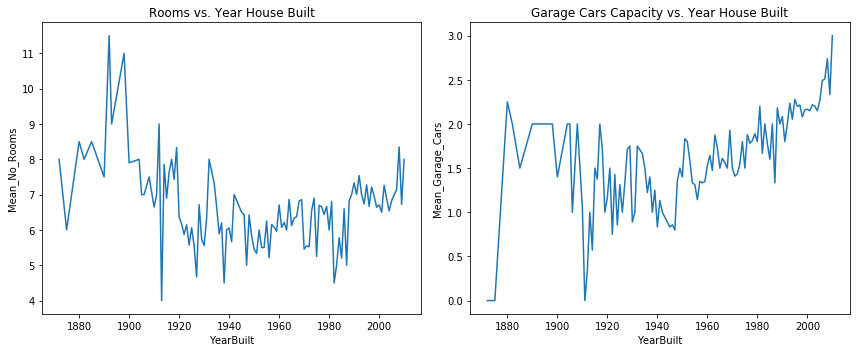

In [216]:
figures, axes = plt.subplots(1, 2, figsize=(12,5))

# TotRmsAbvGrd
totalRoomsYearAgg = train_set.groupby(["YearBuilt"])["TotRmsAbvGrd"].agg(["mean"]).reset_index()
totalRoomsYearAgg = totalRoomsYearAgg.rename(columns={"mean": "Mean_No_Rooms"})
sns.lineplot(x="YearBuilt", y="Mean_No_Rooms", data=totalRoomsYearAgg, markers=True, ax=axes[0])
axes[0].set_title("Rooms vs. Year House Built")
# GarageCars

garageCarsYearAgg = train_set.groupby(["YearBuilt"])["GarageCars"].agg(["mean"]).reset_index()
garageCarsYearAgg = garageCarsYearAgg.rename(columns={"mean": "Mean_Garage_Cars"})
sns.lineplot(x="YearBuilt", y="Mean_Garage_Cars", data=garageCarsYearAgg, markers=True, ax=axes[1])
axes[1].set_title("Garage Cars Capacity vs. Year House Built")

plt.tight_layout()

### Conclusion (Task 2 - LineChart):
Changes in Mean number of rooms as the houses are built through a period of time
1. Steady increase from 6 room to 11 rooms from 1880 to 1900
2. Significant drop in mean no. of rooms from 1900s till 1940s (possible due to world war atmosphere people were hesitating to build full-fledge houses to avoid rebuilding)
3. A gradual increase in mean no. of rooms from 1950s to late 2000s (possible due to rise in nuclear family trends as time proceeded, due to reduction in few people per house)

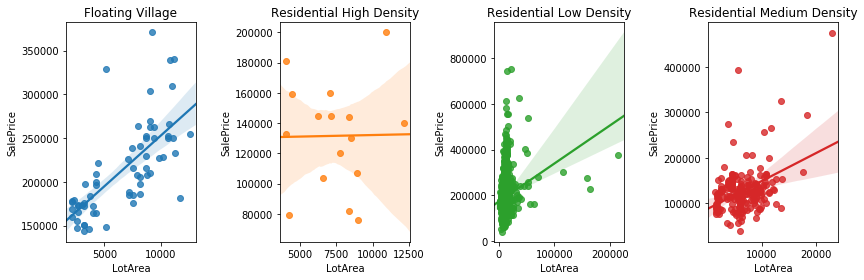

In [217]:
figures, axes = plt.subplots(1, 4, figsize=(12,4))
residency_types = ['FV', 'RH','RL','RM']
labels = ["Floating Village", "Residential High Density", "Residential Low Density", "Residential Medium Density"]
for index, residency_type in enumerate(residency_types):
    residency = train_set[train_set.MSZoning == residency_type]
    sns.regplot(x='LotArea', y='SalePrice', data=residency, ax=axes[index])
    axes[index].set_title(labels[index])

plt.tight_layout()

### Conclusion (Task 2 - ScatterPlot):
1. In Floating Village, Low Density, Medium Density Residential zones a strong correlation in SalePrice at Lot-Area is observed
2. In Highly Dense Residential, there's no correlation between SalePrice vs LotArea (may be there are other factors that influence SalePrice in High Residential Zones other than Lot-Area)

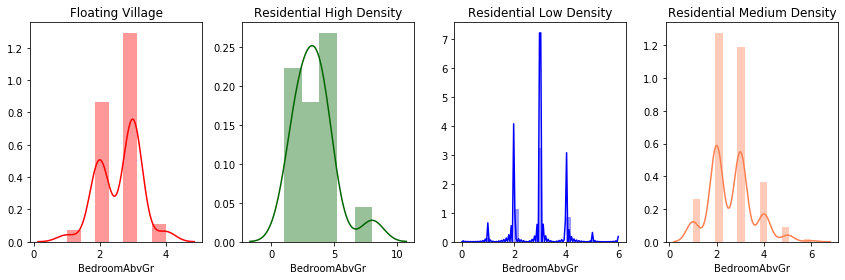

In [218]:
figures, axes = plt.subplots(1, 4, figsize=(12,4))
residency_types = ['FV', 'RH', 'RL', 'RM']
labels = ["Floating Village", "Residential High Density", "Residential Low Density", "Residential Medium Density"]
colors = ['red', 'darkgreen', 'blue', 'coral']
for index, residency_type in enumerate(residency_types):
    residency_data = train_set[train_set.MSZoning == residency_type]
    sns.distplot(residency_data.BedroomAbvGr, ax=axes[index], color=colors[index])
    axes[index].set_title(labels[index])
plt.tight_layout()

### Conclusion (Task 2 - Histogram):
1. Average number of bedrooms range in 1 to 5 in Residential High Density
2. Maximum residents in Residential Low Density live within houses of 3 bedrooms


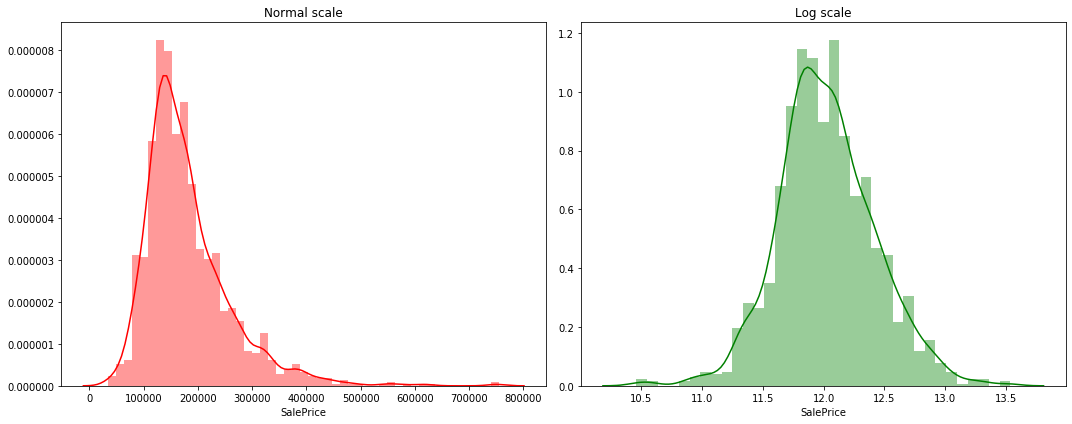

In [228]:
figures, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.distplot(train_set["SalePrice"], ax=axes[0], color='red')
axes[0].set_title("Normal scale")

sns.distplot(np.log(train_set["SalePrice"]), ax=axes[1], color='green')
axes[1].set_title("Log scale")

plt.tight_layout()

### Conclusion (Task 2):
1. By inspecting the right-tail of SalePrice on normal scale, we could infer that there are outlier houses sold at exorbitant SalePrices
2. On logarithmic scale, we could identify that logarithm of SalePrice is a bell shaped curve (may be making predictions of logarithm of SalePrice would be easier)

In [241]:
neighborhood_lot_area = train_set.groupby(['Neighborhood'])["LotArea"].agg(["mean"]).reset_index()
neighborhood_lot_area = neighborhood_lot_area.rename(columns={"mean": "LotAreaOfHouses"})

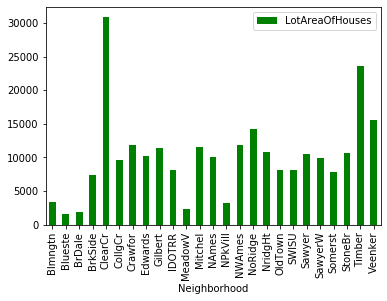

In [242]:
# sns.violinplot([neighborhood_lot_area.mean, neighborhood_lot_area.Neighborhood])
neighborhood_lot_area.plot.bar(x='Neighborhood', y='LotAreaOfHouses', color='green')

## Conclusion (Task 2):
1. There are houses with larger lot area in some neighborhoods: Clear Creek, Timber, Veenker
2. There are some neighborhoods with extremely less lot area in square feet: Bloomington, Bluestem, Brookside, Meadow Village, North Park Villa

## Task 3

In [243]:
def max_min_scaler(min_val, max_val, val):
    return (val - min_val)/(max_val - min_val)

## Desirability Score:
1. Took significantly correlated features and applied min-max scaling on them to compute their score
2. Took other features which dictated high Sale Prices in their pivot group: type of house/type of street/type of exterior condition/year built/pool area
3. Applied min-max scaling to compute score on each feature
4. Normalised all scores and computed a rating on a scale from 1 to 10 to express desirability
5. The basic intuition behind desirability scores, is that the most desirable houses would be expensive because of the high economical demand. In other words, desirable features would dictate high Sale-Prices

In [244]:
max_int = sys.maxsize - 1 # Maximum possible integer value in python
min_int = (-max_int - 1) + 2 # Minimum possible integer value in python
def desirability_score(row):
    score = 0.0
    correlated_cols_weights = {"OverallQual": 0.79, "GrLivArea": 0.70, "GarageCars": 0.64 , "GarageArea": 0.62, "TotalBsmtSF": 0.61, "1stFlrSF": 0.60}
    correlated_cols_mins = {"OverallQual": 1.0, "GrLivArea": 334.0, "GarageCars": 0.0, "GarageArea": 0.0, "TotalBsmtSF": 0.0, "1stFlrSF": 334.0}
    correlated_cols_max = {"OverallQual": 10.0, "GrLivArea": 5642.0, "GarageCars": 5.0, "GarageArea": 1488.0, "TotalBsmtSF": 6110.0, "1stFlrSF": 5095.0}
    for c in correlated_cols_weights:
        score += max_min_scaler(correlated_cols_mins[c], correlated_cols_max[c], row[c])
    
#     print(str(score))
    
    # Higher weight if a 2 Story or newer dwelling then assign higher score
    if row["MSSubClass"] in [20, 60, 0, 75, 160]:
        score += 1.0
    else:
        score += 0.0
    
    # Higher weight if the street closed to house is Paved or made from Gravel
    if row["Street"] == "Pave":
        score += 1.0
    else:
        score += 0.0
        
    # Higher weight if the exterior material quality is Excellent
    if row["ExterCond"] == "Ex":
        score += 1.0
    else:
        score += 0.0
                
    neighborhood = ['MeadowV', 'IDOTRR', 'BrDale', 'BrkSide', 'Edwards', 'OldTown', 'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel', 'SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn', 'CollgCr', 'Crawfor', 'ClearCr', 'Somerst', 'Veenker', 'Timber', 'StoneBr', 'NridgHt', 'NoRidge']
    
    
    score += neighborhood.index(row["Neighborhood"])/10.0

    year_built_min, year_built_max = 1872.0, 2010.0
    year_remod_min, year_remod_max = 1950.0, 2010.0
    pool_area_min, pool_area_max = 0.0, 800.0
    
    score += max_min_scaler(year_built_min, year_built_max, row["YearBuilt"])
    score += max_min_scaler(year_remod_min, year_remod_max, row["YearRemodAdd"])
    score += max_min_scaler(pool_area_min, pool_area_max, row["PoolArea"])
    
#   In total we added 6 pearson-corrleation based numerical scores, type of dwelling score, type of street score, material quality of score, type of neighborhood score,
#   , year-built, year-remodeled, pool area based score
#   In total: 6 + 1 + 1 + 1 + 1 + 1 + 1 + 1 -> 13
#    So, in conclusion we added 13 times sigmoid scaled values
    score /= 13.0
    
    # Now score will be in a range from 0.0 to 1.0,
    # Return a desirability score in a range from 1 to 10.0
        
    return score * 10.0
        
    

In [245]:
train_set["desirability"] = train_set.apply(desirability_score, axis=1)

In [246]:
sorted_train_df = train_set.sort_values(by=["desirability"], ascending=False)
most_desirable = sorted_train_df[:10]
least_desirable = sorted_train_df[-10:].sort_values(by=["desirability"])

In [247]:
house_identifiers = ["Id", "MSSubClass", "MSZoning", "LotArea", "Neighborhood", "BldgType", "YearBuilt", "GarageCars", "PoolArea", "OverallQual", "OverallCond", "desirability"]

In [248]:
least_desirable[house_identifiers]

,Id,MSSubClass,MSZoning,LotArea,Neighborhood,BldgType,YearBuilt,GarageCars,PoolArea,OverallQual,OverallCond,desirability
705,706,190,RM,5600,IDOTRR,2fmCon,1930,0,0,4,5,1.541852
495,496,30,C (all),7879,IDOTRR,1Fam,1920,0,0,4,5,1.579073
375,376,30,RL,10020,Edwards,1Fam,1922,0,0,1,1,1.616316
636,637,30,RM,6120,BrkSide,1Fam,1936,0,0,2,3,1.618275
1325,1326,30,RM,3636,IDOTRR,1Fam,1922,0,0,4,4,1.623083
968,969,50,RM,5925,OldTown,1Fam,1910,0,0,3,6,1.746998
620,621,30,RL,8248,Edwards,1Fam,1914,0,0,3,3,1.753191
1323,1324,30,RL,5330,BrkSide,1Fam,1940,0,0,4,7,1.802955
1218,1219,50,RM,6240,BrkSide,1Fam,1947,0,0,4,5,1.812844
307,308,50,RM,7920,IDOTRR,1Fam,1920,0,0,6,7,1.849837


In [249]:
most_desirable[house_identifiers]

,Id,MSSubClass,MSZoning,LotArea,Neighborhood,BldgType,YearBuilt,GarageCars,PoolArea,OverallQual,OverallCond,desirability
1182,1183,60,RL,15623,NoRidge,1Fam,1996,3,555,10,5,8.087744
1298,1299,60,RL,63887,Edwards,1Fam,2008,2,480,10,5,7.861911
691,692,60,RL,21535,NoRidge,1Fam,1994,3,0,10,6,7.528131
825,826,20,RL,14803,NridgHt,1Fam,2007,3,0,10,5,7.463215
1373,1374,20,RL,11400,NoRidge,1Fam,2001,3,0,10,5,7.452851
440,441,20,RL,15431,NridgHt,1Fam,2008,3,0,10,5,7.410871
581,582,20,RL,12704,NridgHt,1Fam,2008,3,0,8,5,7.381147
224,225,20,RL,13472,NridgHt,1Fam,2003,3,0,10,5,7.380473
178,179,20,RL,17423,StoneBr,1Fam,2008,3,0,9,5,7.354648
898,899,20,RL,12919,NridgHt,1Fam,2009,3,0,9,5,7.325294


## Task 4

In [262]:
# all_clustering_columns = ['Neighborhood', 'MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','KitchenAbvGr', 'BedroomAbvGr', 'LotShape','LandContour','LotConfig','LandSlope','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','Heating','Electrical','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','Fence','SalePrice']
# all_clustering_columns = ['desirability_score', '1stFlrSF', 'BldgType', 'Condition1', 'DesiringScore', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fireplaces', 'Foundation', 'FullBath', 'GarageArea', 'GarageCars', 'GrLivArea', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'OverallQual', 'SaleCondition', 'SalePrice', 'SaleType', 'TotRmsAbvGrd', 'TotalBsmtSF']


### Citation:
https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical

### Citation:
Categorical Encoding: https://pbpython.com/categorical-encoding.html </br>
Normalization: https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn </br>

In [224]:
## Converting categorical columsn

    

In [225]:
# scaler = preprocessing.MinMaxScaler()
# filtered_columns = cluster_base_df.columns.tolist()
# cluster_base_df[filtered_columns] = scaler.fit_transform(cluster_base_df[filtered_columns])

### Citation:
https://www.geeksforgeeks.org/python-pandas-dataframe-nlargest/

## Task 4:
1. Implementing pair-wise distance function to indicate similarity between houses and not actual Neighborhood of locations (as it was clarified at piazza: https://piazza.com/class/jz8whi1ldz0245?cid=62 by Professor Skiena)

In [269]:
train_set = pd.read_csv("data/train.csv")

In [273]:
train_set.LandSlope.value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [285]:
train_set.PoolArea.isnull().sum()

0

In [293]:
# all_clustering_columns = ['desirability', 'MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','KitchenAbvGr', 'BedroomAbvGr', 'LotShape','LandContour','LotConfig','LandSlope','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','Heating','Electrical','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','Fence','SalePrice']

clustering_cols = ['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape', 'Utilities', 'LandContour', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'TotalBsmtSF', 'Heating', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'PoolArea']

cluster_base_df = train_set[clustering_cols].copy(deep=True)
cluster_base_df = cluster_base_df[clustering_cols]

numeric_cols = cluster_base_df._get_numeric_data().columns
categorical_cols = list(set(cluster_base_df.columns) - set(numeric_cols))

for c in categorical_cols:
    one_hot_encoding = pd.get_dummies(cluster_base_df[c], prefix=c)
    cluster_base_df = cluster_base_df.drop(c, axis=1)
    cluster_base_df = cluster_base_df.join(one_hot_encoding)

# deep_copy_df = deep_copy_df.drop(, axis=1)

In [295]:
cluster_base_df.head()

,MSSubClass,LotArea,TotalBsmtSF,FullBath,KitchenAbvGr,TotRmsAbvGrd,GarageCars,PoolArea,Street_Grvl,Street_Pave,...,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed
0,60,8450,856,2,1,8,2,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,20,9600,1262,2,1,6,2,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2,60,11250,920,2,1,6,2,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3,70,9550,756,1,1,7,3,0,0,1,...,0,0,0,1,0,1,0,0,0,0
4,60,14260,1145,2,1,9,3,0,0,1,...,0,0,0,1,0,1,0,0,0,0


### Similarity measures attempted
1. Inverse cosine similarity, since a majority tries to minimize the mesaure-value and for cosine, higher the value it is more similar are the vectors
2. Euclidean distance
3. Euclidean distance/(noise + cosine similarity)

In [296]:
def inverse_cossim(x, y):
    return 1.0 - (np.dot(x, y)/(np.linalg.norm(x) * np.linalg.norm(y)))

def cossim(x, y):
    return np.dot(x, y)/(np.linalg.norm(x) * np.linalg.norm(y))

def euclid_distance(x, y):
    return np.linalg.norm(x-y)

def euclid_cosine(x, y):
    noise = 10**(-6)
    return euclid_distance(x, y)/(noise + cossim(x, y))

In [297]:
def affinity_measure(x):
    return pairwise_distances(x, metric=euclid_distance)

## Citation
https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

In [298]:
cluster = AgglomerativeClustering(n_clusters=15, affinity=affinity_measure, linkage='average')

In [299]:
clusters = cluster.fit(cluster_base_df.values)

In [300]:
cluster_base_df["cluster_ids"] = clusters.labels_
cluster_base_df["cluster_ids"].value_counts()

1     1190
5      148
10      68
0       32
2        7
4        4
9        2
6        2
14       1
13       1
12       1
11       1
8        1
7        1
3        1
Name: cluster_ids, dtype: int64

In [307]:
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(cluster_base_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1460 samples in 0.003s...
[t-SNE] Computed neighbors for 1460 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1460
[t-SNE] Computed conditional probabilities for sample 1460 / 1460
[t-SNE] Mean sigma: 15.537352
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.167839
[t-SNE] KL divergence after 1000 iterations: 0.429312


In [309]:
cluster_base_df["first_component"] = tsne_results[:, 0]
cluster_base_df["second_component"] = tsne_results[:, 1]

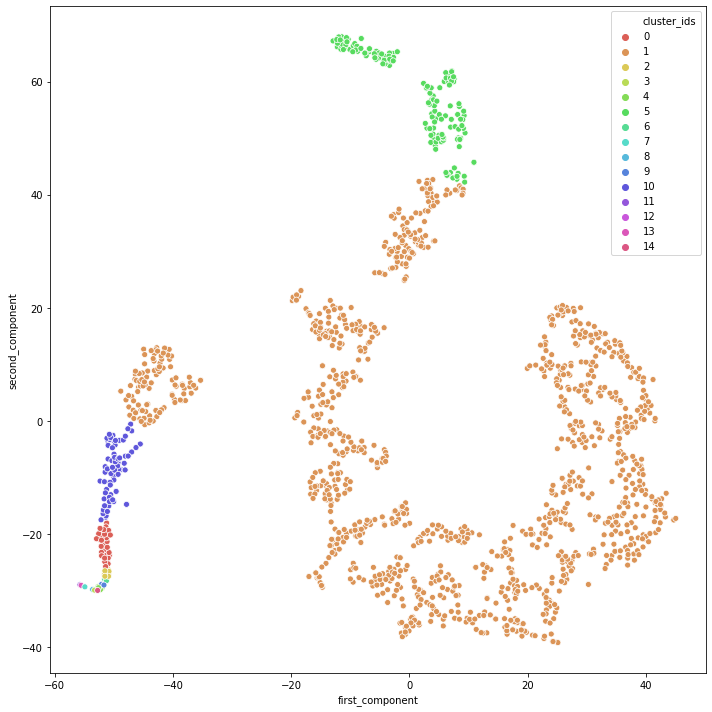

In [310]:
figures, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
sns.scatterplot(x="first_component", y="second_component", hue="cluster_ids", palette=sns.color_palette("hls", 15), data=cluster_base_df, legend="full", ax=axes)
plt.tight_layout()

In [1]:
original_df = train_set.copy(deep=True)

NameError: name 'train_set' is not defined

In [235]:
original_df["cluster_ids"] = cluster_base_df["cluster_ids"]

In [236]:
neighborhood_values = list(original_df.Neighborhood.unique())

## Citation:
Batching: https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks

In [249]:
# figures, axes = plt.subplots(1, 3)

cluster_neighbor = {}
sample_plots = 0
for i in range(20):
    filter_df = original_df[original_df["cluster_ids"] == i].groupby(["Neighborhood"])["SalePrice"].agg(["count"]).reset_index()
    shapes = filter_df.shape
#     print(str(shapes))
#     if shapes[0] > 2 and shapes[0] < 10 and sample_plots < 3:
#         sns.countplot(x='Neighborhood', data=filter_df, ax=axes[sample_plots])
#         axes[sample_plots].set_title("Cluster number: " + str(i))
#         sample_plots += 1

    if shapes[0] > 0:
        cluster_neighbor[i] = filter_df.iloc[filter_df["count"].idxmax()]["Neighborhood"]
    
# plt.tight_layout()
    

In [250]:
cluster_neighbor

{0: 'NAmes',
 1: 'NridgHt',
 2: 'ClearCr',
 3: 'Edwards',
 4: 'NridgHt',
 5: 'NoRidge',
 6: 'CollgCr',
 7: 'NoRidge',
 8: 'NridgHt',
 9: 'ClearCr',
 10: 'NridgHt',
 11: 'Timber',
 12: 'Edwards',
 13: 'Timber',
 14: 'ClearCr'}

## Task 6
(Performed two experiments with different set of features)

### Task 6 <Experiment 1>:
Features (OverallQual, YearBuilt, YrSold, MoSold, GarageCars)

In [35]:
train_simple_df = pd.read_csv("data/train.csv")

In [46]:
feature_columns = ['OverallQual', 'YearBuilt', 'YrSold', 'MoSold', 'MSSubClass', 'KitchenAbvGr']
features = train_simple_df[feature_columns]

X_train, X_test, y_train, y_test = train_test_split(features, train_simple_df['SalePrice'], test_size=0.2, random_state=31)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

regressor = LinearRegression()
regressor = regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

exp1_mean_absolute_error = mean_absolute_error(y_test, y_pred)
exp1_mean_squared_error = mean_squared_error(y_test, y_pred)
exp1_root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:', exp1_mean_absolute_error)  
print('Mean Squared Error:', exp1_mean_squared_error)  
print('Root Mean Squared Error:', exp1_root_mean_squared_error)

Mean Absolute Error: 33895.86159739025
Mean Squared Error: 2781789556.7450905
Root Mean Squared Error: 52742.673014790314


### Task 6 <Experiment 2> :
Not including Time of the house was sold

In [47]:
feature_columns = ['OverallQual', 'YearBuilt', 'GarageCars', 'TotalBsmtSF', 'GrLivArea']
features = train_simple_df[feature_columns]

X_train, X_test, y_train, y_test = train_test_split(features, train_simple_df['SalePrice'], test_size=0.2, random_state=31)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

regressor = LinearRegression()
regressor = regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

exp2_mean_absolute_error = mean_absolute_error(y_test, y_pred)
exp2_mean_squared_error = mean_squared_error(y_test, y_pred)
exp2_root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:', exp2_mean_absolute_error)  
print('Mean Squared Error:', exp2_mean_squared_error)  
print('Root Mean Squared Error:', exp2_root_mean_squared_error)

Mean Absolute Error: 25993.601955901704
Mean Squared Error: 1875664560.4257133
Root Mean Squared Error: 43308.94319220585


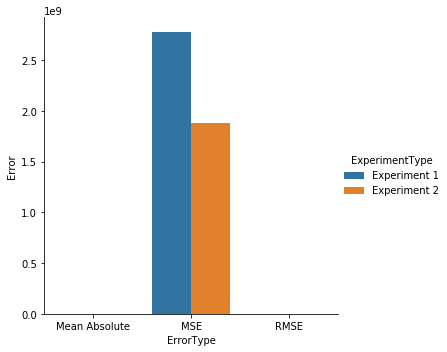

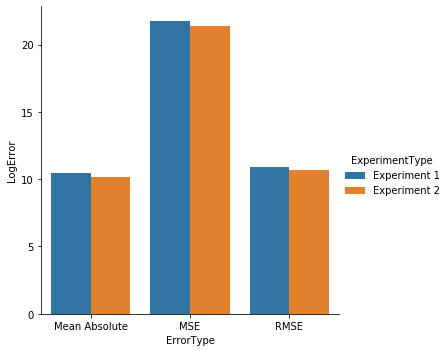

In [80]:
# figures, axes = plt.subplots(nrows=1, ncols=2)
error_df = pd.DataFrame({"Error": [exp1_mean_absolute_error, exp1_mean_squared_error, exp1_root_mean_squared_error,
                        exp2_mean_absolute_error, exp2_mean_squared_error, exp2_root_mean_squared_error],
              "ErrorType": ["Mean Absolute", "MSE", "RMSE", "Mean Absolute", "MSE", "RMSE"],
              "ExperimentType": ["Experiment 1", "Experiment 1", "Experiment 1",
                                 "Experiment 2", "Experiment 2", "Experiment 2"]})

error_df["LogError"] = np.log(error_df["Error"])

# error_df

sns.catplot(x="ErrorType", y="Error", hue="ExperimentType", data=error_df, kind="bar")
sns.catplot(x="ErrorType", y="LogError", hue="ExperimentType", data=error_df, kind="bar")

### Conclusion (Task 6): 
1. Comparing results of Experiment 1 and Experiment 2 help us identify that certain features are relevant, while some are not
2. Although we could observe difference in RMSE between Experiment 1 and Experiment 2 is roughly ~ 10000, on a log scale we could difference w.r.t all types of errors
3. In other words, we need to engineer features as well normalize and scale values

## Task 7
1. External dataset: https://www.cityofames.org/government/departments-divisions-a-h/city-assessor/reports#GeneralReports (Ames)
2. Citation: This external data-set for analysis was gathered from government website: cityofames.org

In [201]:
internal_data = pd.read_csv("data/train.csv")
external_df = pd.read_csv("data/Ames Real Estate Data.csv")

C:\Users\Paras\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,17,35,36,40,81) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [202]:
ames_df = external_df[external_df['MA_City'] == 'AMES']
neighborhood_land_value = ames_df.groupby('Neighborhood')['LndAc_S'].agg(['mean']).reset_index()
neighborhood_land_value = neighborhood_land_value.rename(columns={'mean': 'land_value'})

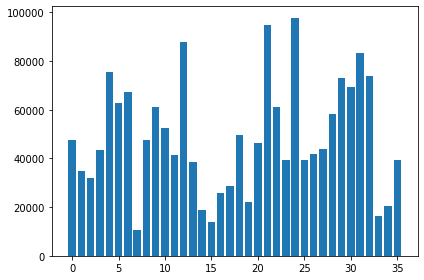

In [203]:
plt.bar(np.arange(len(neighborhood_land_value.land_value.values)), neighborhood_land_value.land_value.values)
plt.tight_layout()

#### Land value has a good variance across 36 different neighborhoods, we can use it in our own dataset
#### We could join on Neighborhood, and add a new column of Land Value to check a basic performance of the model

In [204]:
internal_data = pd.merge(internal_data, neighborhood_land_value, on=['Neighborhood'], how='inner')

In [207]:
feature_columns = ['OverallQual', 'YearBuilt', 'GarageCars', 'TotalBsmtSF', 'GrLivArea', 'land_value']
features = internal_data[feature_columns]

X_train, X_test, y_train, y_test = train_test_split(features, internal_data['SalePrice'], test_size=0.2, random_state=31)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

regressor = LinearRegression()
regressor = regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

exp2_mean_absolute_error = mean_absolute_error(y_test, y_pred)
exp2_mean_squared_error = mean_squared_error(y_test, y_pred)
exp2_root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:', exp2_mean_absolute_error)  
print('Mean Squared Error:', exp2_mean_squared_error)  
print('Root Mean Squared Error:', exp2_root_mean_squared_error)

Mean Absolute Error: 23338.617014012943
Mean Squared Error: 1127749418.8223724
Root Mean Squared Error: 33581.98056729788


#### Conclusion
1. Our RMSE definitiely improved (from ~43k of Experiment 2 in Task 6) to ~33k for same set of signals after including land_value from external data-set
2. We didn't have common unique-id column in our external data-set of Ames and the data-set of Kaggle
3. Hence, we needed to aggregate on land-value in Neighborhood and join on that with out kaggle data-set
4. Given that we are aggregating, we still got small improvement in RMSE
5. This could be explained by fact, that Land-Value also plays some amount of role in dictating in SalePrice

#### Collaborators for data-source:
1. Ruchit Modi, Mohit Gurnani

## Task 8
1. Alternative Hypothesis: Our selected signal is significant with respect to SalesPrice
2. Null Hypothesis: Our selected signal is not significant with respect to SalesPrice
3. Setting significance level at 1 %
4. If the p-value is less than our significance level then our true observed score doesn't predict on the basis of luck, and our predictor could explain the data correctly
5. If the p-value is greater than our significance level then our true observed score is as good as some random score


In [14]:
train_set = pd.read_csv("data/train.csv")

sale_price_corr = train_set.corr()['SalePrice']

In [15]:
sale_price_corr.nlargest(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

In [16]:
sale_price_corr.nsmallest(10)

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64

## Most important features to attempt
OverallQual </br>
YearBuilt </br>
TotalBsmtSF </br>
GarageCars </br>
1stFlrSF </br>

MasVnrArea </br>

## Least important features to attempt
MoSold </br>
YrSold </br>
MSSubClass </br>
3SsnPorch </br>
KitchenAbvGr </br>


In [17]:
train_set = pd.read_csv("data/train.csv")

In [18]:
def fit_single_variable_regressor(X_train, y_train):
    regressor = LinearRegression()
    regressor = regressor.fit(X_train, y_train)
    
    return regressor

In [19]:
def score_observation(regressor, X_test, y_test):
    '''
        Computes Root Mean Square Error of natural log of prices
        A small amount of noise is added to avoid NaNs
    '''
    noise = 0.000000001
    y_pred = regressor.predict(X_test)
    errors = np.square(np.log(y_test + noise) - np.log(y_pred + noise) + noise)
    errors = errors[~np.isnan(errors)]
    observation = np.sqrt(np.sum(errors)/len(errors))
    
    return observation

In [20]:
def calculate_p_value(true_observation, permuted_observation_scores):
    counts = 0.0
    for score in permuted_observation_scores:
        if true_observation > score:
            counts += 1.0

    
    p_value = counts / (len(permuted_observation_scores) + 1)

    return p_value

In [21]:
def permutation_test(single_feature, train_set, axes, significance_level):
    axes.set_title(single_feature)
    train_single = train_set[[single_feature, 'SalePrice']]

    X_train, X_test, y_train, y_test = train_test_split(train_single.drop(['SalePrice'], axis=1), train_single['SalePrice'], test_size=0.2, random_state=31)

    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    regressor = fit_single_variable_regressor(X_train, y_train)
    true_observation = score_observation(regressor, X_test, y_test)
    
    permuted_observation_scores = []
    for i in range(1000):
        np.random.shuffle(y_train)
        regressor = fit_single_variable_regressor(X_train, y_train)
        observation_score = score_observation(regressor, X_test, y_test)
        permuted_observation_scores.append(observation_score)
    
    sns.distplot(np.array(permuted_observation_scores), bins=10, ax=axes)
    axes.axvline(true_observation, color='m', linestyle='dashed', linewidth=1)
    axes.axvline(np.array(permuted_observation_scores).mean(), color='k', linestyle='dashed')

    p_value = calculate_p_value(true_observation, permuted_observation_scores)
    
    permutation_score_mean_patch = mpatches.Patch(color='black', label='Permutation score mean: ' + str(round(np.array(permuted_observation_scores).mean(), 2)))
    true_score_patch = mpatches.Patch(color='cyan', label='True score: ' + str(round(true_observation, 2)))
    p_value_patch = mpatches.Patch(color='magenta', label='p-value: ' + str(round(p_value, 2)))
    
    if p_value < significance_level:
        conclusion_patch = mpatches.Patch(color='green', label='Null Hypothesis rejected')
    else:
        conclusion_patch = mpatches.Patch(color='red', label='Null Hypothesis accepted')


    axes.legend(handles=[permutation_score_mean_patch, true_score_patch, p_value_patch, conclusion_patch])
#     axes.legend(handles=[permutation_score_mean_patch, true_score_patch, p_value_patch])
    
    return p_value, permuted_observation_scores

    

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


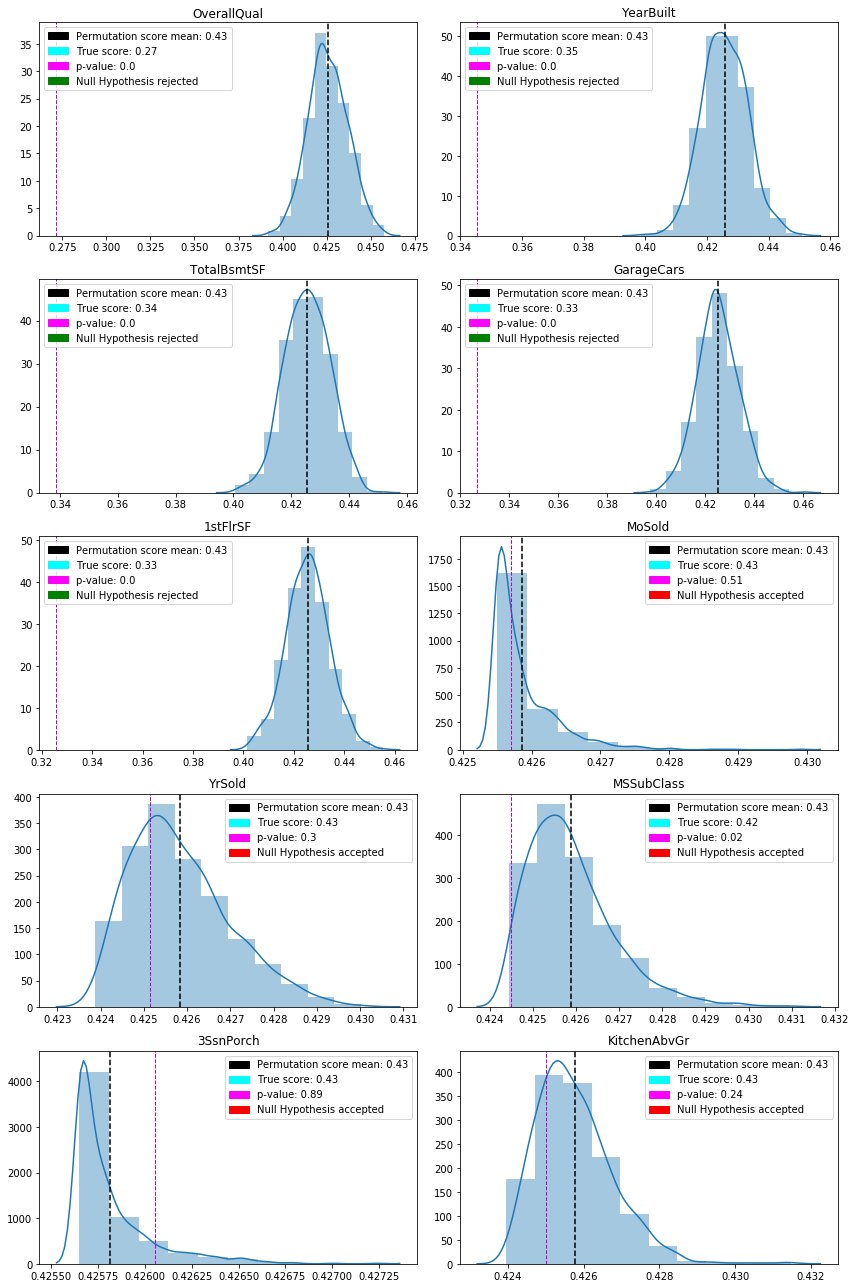

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,18))
features_to_explore = ['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GarageCars', '1stFlrSF', 'MoSold', 'YrSold', 'MSSubClass', '3SsnPorch', 'KitchenAbvGr']
# features_to_explore = ['OverallQual']
for index, single_feature in enumerate(features_to_explore):
    row_index = index//2
    col_index = index % 2
    p_value, permutation_score = permutation_test(single_feature, train_set, axes[row_index][col_index], significance_level=0.01)

plt.tight_layout()

## Conclusion (Task 8):
1. For strong features -> Overall-quality, Year house was built, basement size in square feet, no. of garage cars, 1st floor square feet </br>
    a. We got p-values less than our significance level of (1 %) </br>
    b. This means our regressor didn't predict correct values on the basis of just luck and actually learned some signals around above features </br>
    c. Hence, we reject our null hypothesis and conclude that above features are significant </br>
2. For weak features -> Month house was sold, year house was sold, type of house, three season porch, kitchens </br>
    a. We got p-values greater than our significance level of (1 %) </br>
    b. This means our regressor performed well enough for both correct as well as corrupted data </br>
    c. Hence, our null hypothesis comes out true and conclude that regressor on above features could not explain the data well </br>


## Task 9
Feature Engineering for best prediction model

In [81]:
train_base = pd.read_csv("data/train.csv")
test_base = pd.read_csv("data/test.csv")
test_base['SalePrice'] = -1.0
global_set = pd.concat([train_base,test_base])


global_cols = set(global_set.columns.tolist())
train_cols = set(train_base.columns.tolist())
test_cols = set(test_base.columns.tolist())

In [82]:
len(test_base)

1459

In [83]:
len(train_base)

1460

In [84]:
null_features = global_set.isnull().sum().sort_values(ascending=False)

In [85]:
null_features = null_features.reset_index(name='counts')
null_features['percent'] = 100.0 * null_features['counts']/len(global_set)

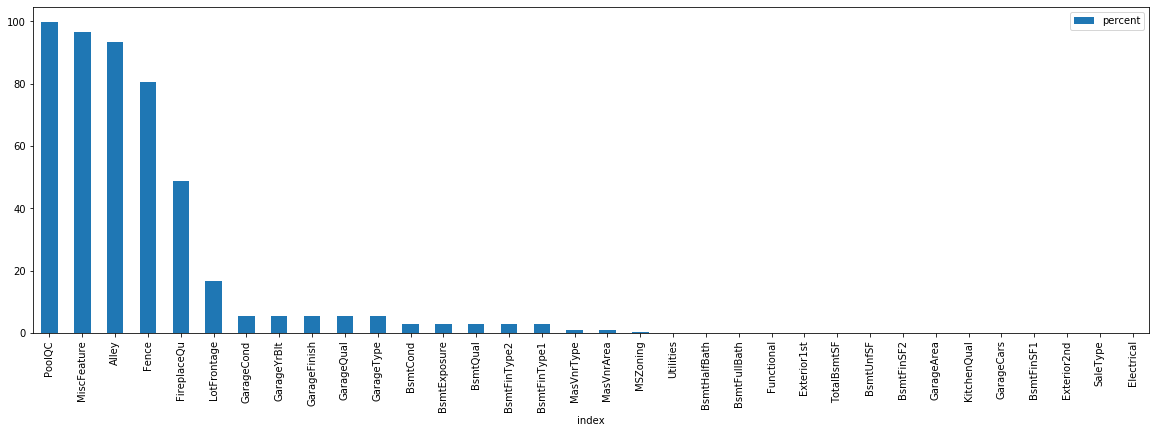

In [86]:
figures, axes = plt.subplots(1,1, figsize=(20,6))
null_features[null_features['percent'] > 0][['percent', 'index']].plot.bar(x='index', ax=axes)

### Conclusion
Null features to drop: </br> 
PoolQC, MiscFeature, Alley, Fence </br>
(Since they are null for more than 80% of values)

In [87]:
features_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
global_set = global_set.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)
features_to_impute = list(set(null_features[null_features.counts > 0]['index']) - set(features_to_drop))

In [88]:
print(str(features_to_impute))

['GarageFinish', 'TotalBsmtSF', 'Utilities', 'Exterior1st', 'BsmtFinSF1', 'GarageArea', 'SaleType', 'GarageType', 'Electrical', 'BsmtCond', 'BsmtQual', 'FireplaceQu', 'BsmtFinType2', 'MasVnrType', 'BsmtFullBath', 'BsmtFinType1', 'Functional', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2', 'MSZoning', 'GarageYrBlt', 'GarageCars', 'GarageCond', 'BsmtExposure', 'LotFrontage', 'KitchenQual', 'GarageQual', 'Exterior2nd', 'MasVnrArea']


In [89]:
numerical_cols = set(global_set._get_numeric_data().columns.tolist())
categorical_cols = set(global_set.columns.tolist()) - numerical_cols

In [90]:
numerical_cols_to_impute = set(features_to_impute) - categorical_cols
print(str(numerical_cols_to_impute))

{'LotFrontage', 'BsmtHalfBath', 'BsmtUnfSF', 'BsmtFinSF2', 'TotalBsmtSF', 'GarageCars', 'GarageYrBlt', 'BsmtFinSF1', 'GarageArea', 'BsmtFullBath', 'MasVnrArea'}


#### As per above bar-plot, LotFrontage is the most frequent numerical column to impute, hence imputing it with median values
#### For rest of the other rare (single digit %) numerical columns imputing them with mode

In [91]:
global_set["LotFrontage"] = global_set.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for c in list(numerical_cols_to_impute - set(["LotFrontage"])):
    global_set[c].fillna(global_set[c].mode()[0])
global_set[list(numerical_cols_to_impute)] = global_set[list(numerical_cols_to_impute)].fillna(0)

In [92]:
categorical_cols_to_impute = set(features_to_impute) - numerical_cols
print(str(categorical_cols_to_impute))

{'GarageFinish', 'Utilities', 'Exterior1st', 'SaleType', 'GarageType', 'Electrical', 'BsmtCond', 'BsmtQual', 'FireplaceQu', 'BsmtFinType2', 'MasVnrType', 'BsmtFinType1', 'Functional', 'MSZoning', 'GarageCond', 'BsmtExposure', 'KitchenQual', 'GarageQual', 'Exterior2nd'}


#### Since, as per data_description.txt, most of these categorical columns have signified NA as "not available"
#### Hence, marking them as "Not available"

In [93]:
for c in list(categorical_cols_to_impute):
    global_set[c] = global_set[c].fillna('Not available')

### Handling skewed features
Citation: https://www.geeksforgeeks.org/python-pandas-dataframe-skew/

In [94]:
skewed_params = global_set[numerical_cols].apply(lambda x: skew(x.dropna())) 
skewed_params = skewed_params[skewed_params > 0.80]
skewed_params = skewed_params.index
skewed_params = list(skewed_params)

### Pre-processing train-test data

In [96]:
train_pre_process = global_set[global_set["SalePrice"] != -1]
test_pre_process = global_set[global_set["SalePrice"] == -1]

In [97]:
train_pre_process[skewed_params] = np.log1p(train_pre_process[skewed_params])
test_pre_process[skewed_params] = np.log1p(test_pre_process[skewed_params])

C:\Users\Paras\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log1p
  


### Encoding categorical columns in training set

In [98]:
numeric_cols = train_pre_process._get_numeric_data().columns
categorical_cols = list(set(train_pre_process.columns) - set(numeric_cols))

total_cat_cols = len(categorical_cols)
done = 0
for c in categorical_cols:
    print("Done: {0}, total: {2}, processing: {1}".format(str(done), str(total_cat_cols), str(c)))
    one_hot_encoding = pd.get_dummies(train_pre_process[c], prefix=c)
    train_pre_process = train_pre_process.drop(c, axis=1)
    train_pre_process = train_pre_process.join(one_hot_encoding)
    done += 1

Done: 0, total: GarageFinish, processing: 39
Done: 1, total: LotShape, processing: 39
Done: 2, total: Utilities, processing: 39
Done: 3, total: Exterior1st, processing: 39
Done: 4, total: SaleType, processing: 39
Done: 5, total: HeatingQC, processing: 39
Done: 6, total: GarageType, processing: 39
Done: 7, total: Electrical, processing: 39
Done: 8, total: CentralAir, processing: 39
Done: 9, total: PavedDrive, processing: 39
Done: 10, total: BsmtCond, processing: 39
Done: 11, total: BsmtQual, processing: 39
Done: 12, total: ExterCond, processing: 39
Done: 13, total: FireplaceQu, processing: 39
Done: 14, total: BsmtFinType2, processing: 39
Done: 15, total: MasVnrType, processing: 39
Done: 16, total: LandSlope, processing: 39
Done: 17, total: Foundation, processing: 39
Done: 18, total: ExterQual, processing: 39
Done: 19, total: Condition2, processing: 39
Done: 20, total: RoofStyle, processing: 39
Done: 21, total: BsmtFinType1, processing: 39
Done: 22, total: Functional, processing: 39
Done

### Encoding categorical columns in test set

In [99]:
# train_cols = set(train_pre_process.columns.tolist())
numeric_cols = test_pre_process._get_numeric_data().columns
categorical_cols = list(set(test_pre_process.columns) - set(numeric_cols))

total_cat_cols = len(categorical_cols)
done = 0
for c in categorical_cols:
    print("Done: {0}, total: {2}, processing: {1}".format(str(done), str(total_cat_cols), str(c)))
    one_hot_encoding = pd.get_dummies(test_pre_process[c], prefix=c)
    test_pre_process = test_pre_process.drop(c, axis=1)
    test_pre_process = test_pre_process.join(one_hot_encoding)
    done += 1


Done: 0, total: GarageFinish, processing: 39
Done: 1, total: LotShape, processing: 39
Done: 2, total: Utilities, processing: 39
Done: 3, total: Exterior1st, processing: 39
Done: 4, total: SaleType, processing: 39
Done: 5, total: HeatingQC, processing: 39
Done: 6, total: GarageType, processing: 39
Done: 7, total: Electrical, processing: 39
Done: 8, total: CentralAir, processing: 39
Done: 9, total: PavedDrive, processing: 39
Done: 10, total: BsmtCond, processing: 39
Done: 11, total: BsmtQual, processing: 39
Done: 12, total: ExterCond, processing: 39
Done: 13, total: FireplaceQu, processing: 39
Done: 14, total: BsmtFinType2, processing: 39
Done: 15, total: MasVnrType, processing: 39
Done: 16, total: LandSlope, processing: 39
Done: 17, total: Foundation, processing: 39
Done: 18, total: ExterQual, processing: 39
Done: 19, total: Condition2, processing: 39
Done: 20, total: RoofStyle, processing: 39
Done: 21, total: BsmtFinType1, processing: 39
Done: 22, total: Functional, processing: 39
Done

In [100]:
train_categorical_cols = set(train_pre_process.columns.tolist())
test_categorical_cols = set(test_pre_process.columns.tolist())
all_categorical_cols = train_categorical_cols.union(test_categorical_cols)
common_cols = all_categorical_cols - (train_categorical_cols - test_categorical_cols) - (test_categorical_cols - train_categorical_cols)

In [101]:
common_cols = list(common_cols)
train_post_process = train_pre_process[common_cols]
test_post_process = test_pre_process[common_cols]

In [135]:
X_train, X_test, y_train, y_test = train_test_split(train_post_process.drop(['SalePrice'], axis=1), train_post_process['SalePrice'], random_state=31)

In [103]:
regressor = LinearRegression()
regressor = regressor.fit(X_train, y_train)

In [123]:
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.09016430142556528
Mean Squared Error: 0.02137383725530401
Root Mean Squared Error: 0.14619793861509817


In [106]:
test_output = regressor.predict(test_post_process.drop(['SalePrice'], axis=1))

In [107]:
test_post_process['SalePrice'] = np.expm1(test_output)

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [108]:
test_post_process[["Id", "SalePrice"]].to_csv("submission.csv", sep=',', index=False)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(train_post_process.drop(['SalePrice'], axis=1), train_post_process['SalePrice'], random_state=31)

In [137]:
xgb_regressor = xgb.XGBRegressor(n_estimators=300, reg_alpha=0.5)

In [138]:
xgb_regressor = xgb_regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

C:\Users\Paras\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:34:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 0.09016430142556528
Mean Squared Error: 0.02137383725530401
Root Mean Squared Error: 0.14619793861509817


In [129]:
test_output = xgb_regressor.predict(test_post_process.drop(['SalePrice'], axis=1))
test_post_process['SalePrice'] = np.expm1(test_output)
test_post_process[["Id", "SalePrice"]].to_csv("xgb_submission.csv", sep=',', index=False)

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
